# Adaptive Cruise Controller (ACC)


The Adaptive Cruise Control (ACC) benchmark is a system that tracks a set
velocity and maintains a safe distance from a lead vehicle by adjusting
the longitudinal acceleration of an ego vehicle.
The neural network computes optimal control actions while satisfying safe
distance, velocity, and acceleration constraints.

In [1]:
using NeuralNetworkAnalysis, MAT
using NeuralNetworkAnalysis: FunctionPreprocessing

## Model

For this case study, the ego car is set to travel at a set speed $v_{set} = 30$
and maintains a safe distance $D_{safe}$ from the lead car.  The car’s dynamics
are described as follows:

$$
\left\{ \begin{array}{lcl}
\dot{x}_{lead}(t) &=& v_{lead}(t) \\
\dot{v}_{lead}(t) &=& \gamma_{lead}(t) \\
\dot{\gamma}_{lead}(t) &=& -2\gamma_{lead}(t) + 2a_{lead}(t) - uv_{lead}^2(t)  \\
\dot{x}_{ego}(t) &=& v_{ego}(t) \\
\dot{v}_{ego}(t) &=& \gamma_{ego}(t) \\
\dot{\gamma}_{ego}(t) &=& -2\gamma_{ego}(t) + 2a_{ego}(t) - uv_{ego}^2(t)
\end{array} \right.
$$
where $x_i$ is the position, $v_i$ is the velocity, $γ_i$ is the
acceleration of the car, $a_i$ is the acceleration control input applied
to the car, and $u = 0.0001$ is the friction parameter, where
$i ∈ \{ego, lead\}$. For this benchmark we are given four neural network
controllers with 3, 5, 7, and 10 hidden layers of 20 neurons each, but only evaluate
the controller with 5 hidden layers. All of them have the same number of inputs
$(v_{set}, T_{gap}, v_{ego}, D_{rel}, v_{rel})$ and one output ($a_{ego}$).

In [2]:
const u = 0.0001  # friction parameter
const a_lead = -2.0  # acceleration control input applied to the lead vehicle

@taylorize function ACC!(dx, x, p, t)
    v_lead = x[2]  # lead car velocity
    γ_lead = x[3]  # lead car acceleration
    v_ego = x[5]  # ego car velocity
    γ_ego = x[6]  # ego car acceleration
    a_ego = x[7]  # ego car acceleration control input

    # lead car dynamics
    dx[1] = v_lead
    dx[2] = γ_lead
    dx[3] = 2 * (a_lead - γ_lead) - u * v_lead^2

    # ego car dynamics
    dx[4] = v_ego
    dx[5] = γ_ego
    dx[6] = 2 * (a_ego - γ_ego) - u * v_ego^2
    dx[7] = zero(a_ego)
    return dx
end

## Specification

The uncertain initial condition is:

$x_{lead}(0) ∈ [90, 110], v_{lead}(0) ∈ [32, 32.2]$,
$γ_{lead}(0) = γ_{ego}(0) = 0, v_{ego}(0) ∈ [30, 30.2], x_{ego} ∈ [10, 11]$

The controller input is
$(v_{set}, T_{gap}, v_{ego}, x_{lead} - x_{ego}, v_{lead} - v_{ego})$.
To extract from the current state the last three inputs to the network
we define a projection matrix $M$.

The verification objective of this system is that given a scenario where
both cars are driving safely, the lead car suddenly slows down with
$a_{lead} = -2$.
We want to check whether there is a collision in the following 5 seconds.
A control period of 0.1 seconds is used.

Formally, the safety specification can be expressed as:
$$
    D_{rel} = x_{lead} - x_{ego} ≥ D_{safe},
$$
where $D_{safe} = D_{default} + T_{gap} * v_{ego}$,
$T_{gap} = 1.4$ sec, and $D_{default} = 10$.
After substitution, the specification reduces to:
$x_{lead} - x_{ego} - T_{gap} * v_{ego} ≥ D_{default}$.

In [3]:
# We choose the controller with 5 hidden layers.
controller = read_nnet_mat(@modelpath("ACC", "controller_5_20.mat");
                           act_key="act_fcns");

# The initial states according to the specification are:
X₀ = Hyperrectangle(low=[90, 32, 0, 10, 30, 0],
                    high=[110, 32.2, 0, 11, 30.2, 0])
U₀ = ZeroSet(1);

# The system has 6 state variables and 1 control variable:
vars_idx = Dict(:state_vars=>1:6, :control_vars=>7)
ivp = @ivp(x' = ACC!(x), dim: 7, x(0) ∈ X₀ × U₀)
period = 0.1;  # control period

# Preprocessing function for the network input:
v_set = 30.0  # ego car's set speed
T_gap = 1.4
M = zeros(3, 6)
M[1, 5] = 1.0
M[2, 1] = 1.0
M[2, 4] = -1.0
M[3, 2] = 1.0
M[3, 5] = -1.0
function preprocess(X::LazySet)  # version for set computations
    Y1 = Singleton([v_set, T_gap])
    Y2 = linear_map(M, X)
    return cartesian_product(Y1, Y2)
end
function preprocess(X::AbstractVector)  # version for simulations
    Y1 = [v_set, T_gap]
    Y2 = M * X
    return vcat(Y1, Y2)
end
control_preprocessing = FunctionPreprocessing(preprocess)

prob = ControlledPlant(ivp, controller, vars_idx, period;
                       preprocessing=control_preprocessing);

# Safety specification
T = 5.0  # time horizon

D_default = 10.0
d_rel = [1.0, 0, 0, -1, 0, 0, 0]
d_safe = [0, 0, 0, 0, T_gap, 0, 0]

d_prop = d_rel - d_safe
safe_states = HalfSpace(-d_prop, -D_default)
predicate = X -> X ⊆ safe_states;

## Results

To integrate the ODE, we use the Taylor-model-based algorithm:

In [4]:
alg = TMJets(abstol=1e-6, orderT=6, orderQ=1);

To propagate sets through the neural network, we use the `Ai2` algorithm:

In [5]:
alg_nn = Ai2()


function benchmark(; silent::Bool=false)
    # We solve the controlled system:
    silent || println("flowpipe construction")
    res_sol = @timed solve(prob, T=T, alg_nn=alg_nn, alg=alg)
    sol = res_sol.value
    silent || print_timed(res_sol)

    # Next we check the property for an overapproximated flowpipe:
    silent || println("property checking")
    solz = overapproximate(sol, Zonotope)
    res_pred = @timed predicate(solz)
    silent || print_timed(res_pred)
    if res_pred.value
        silent || println("The property is satisfied.")
    else
        silent || println("The property may be violated.")
    end
    return solz
end

benchmark(silent=true)  # warm-up
res = @timed benchmark()  # benchmark
sol = res.value
println("total analysis time")
print_timed(res);

flowpipe construction
  0.485114 seconds (3.41 M allocations: 377.235 MiB, 18.51% gc time)
property checking
  0.000094 seconds (119 allocations: 13.938 KiB)
The property is satisfied.
total analysis time
  0.685494 seconds (3.88 M allocations: 421.388 MiB, 17.23% gc time)


We also compute some simulations:

In [6]:
import DifferentialEquations

println("simulation")
res = @timed simulate(prob, T=T, trajectories=10, include_vertices=true)
sim = res.value
print_timed(res);

simulation
 17.639604 seconds (20.54 M allocations: 1.250 GiB, 2.76% gc time)


Finally we plot the results:

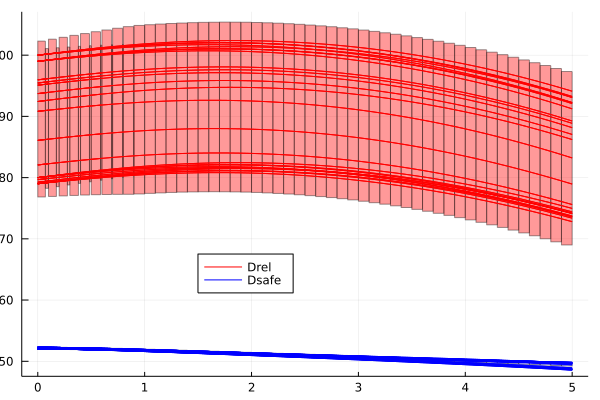

In [7]:
using Plots
import DisplayAs

fig = plot(leg=(0.4, 0.3))
xlabel!(fig, "time")
F = flowpipe(sol)

fp_rel = linear_map(Matrix(d_rel'), F)
output_map_rel = d_rel

fp_safe = affine_map(Matrix(d_safe'), [D_default], F)
output_map_safe = vcat([D_default], d_safe)

plot!(fig, fp_rel, vars=(0, 1), c=:red, alpha=.4)
plot!(fig, fp_safe, vars=(0, 1), c=:blue, alpha=.4)

plot_simulation!(fig, sim; output_map=output_map_rel, color=:red, lab="Drel")
plot_simulation!(fig, sim; output_map=output_map_safe, color=:blue, lab="Dsafe")

fig = DisplayAs.Text(DisplayAs.PNG(fig))
# savefig("ACC.png")
fig